In [179]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import tifffile as tf
from xml.etree import ElementTree as ET
import pickle
import h5py
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
def print_stat(path_xml):
    if not isinstance(path_xml, Path):
        path_xml = Path(path_xml)
    if path_xml.is_dir():
        path_xml = next(path_xml.glob('*.xml'))
    with open(path_xml, 'r', encoding='utf-8') as f:
        xml = ET.parse(f, parser=ET.XMLParser(encoding='utf-8'))

    print(f'Microscope: {xml.find("./Modality").get("name")}')
    print(f'Image size (XY): {xml.find("./LSM").get("pixelX")} x {xml.find("./LSM").get("pixelX")}')
    print(f'FOV (width height): {xml.find("./LSM").get("widthUM")} um x {xml.find("./LSM").get("heightUM")} um')
    print(f'Pixel size: {xml.find("./LSM").get("pixelSizeUM")} um')
    print(f'px/um (FIJI): {1 / float(xml.find("./LSM").get("pixelSizeUM"))} px')
    print(f'Frame Rate: {xml.find("./LSM").get("frameRate")} ms')
    print(f'Dwell time: {xml.find("./LSM").get("dwellTime")} ms')
    print(f'PMT Gain: {xml.find("./PMT").get("gainA")} %')
    print(f'Laser Power: {xml.find("./Pockels").get("start")}% {xml.find("./Pockels").get("stop")}%')
    try:
        val = xml.find('./ExperimentNotes').get('text')
        print("Note --------------")
        print(val)
        print("-------------------")

    except AttributeError:
        pass


In [3]:
#path_dataset = Path('/home/CSHL2024_files/Team_3P3P/3P3P Day3/2P_streaming_vis_stim_500um')
path_dataset = Path(r'C:\Users\knowb\Desktop\2P_streaming_vis_stim_500um')

In [4]:
path_xml = next(path_dataset.glob('*.xml'))
print_stat(path_xml)

Microscope: 2p
Image size (XY): 512 x 512
FOV (width height): 299.93 um x 299.93 um
Pixel size: 0.586 um
px/um (FIJI): 1.7064846416382253 px
Frame Rate: 29.982 ms
Dwell time: 0.08 ms
PMT Gain: 37.3 %
Laser Power: 72.61% 72.61%
Note --------------
mouse 2 - gcamp8
fps 30
-------------------


In [5]:
dot2p_folder = path_dataset / (path_dataset.stem + '.2p')

In [6]:
path_img = next(dot2p_folder.glob('*.tif'))
paths_img_org = sorted(list(path_dataset.glob('*.tif')))

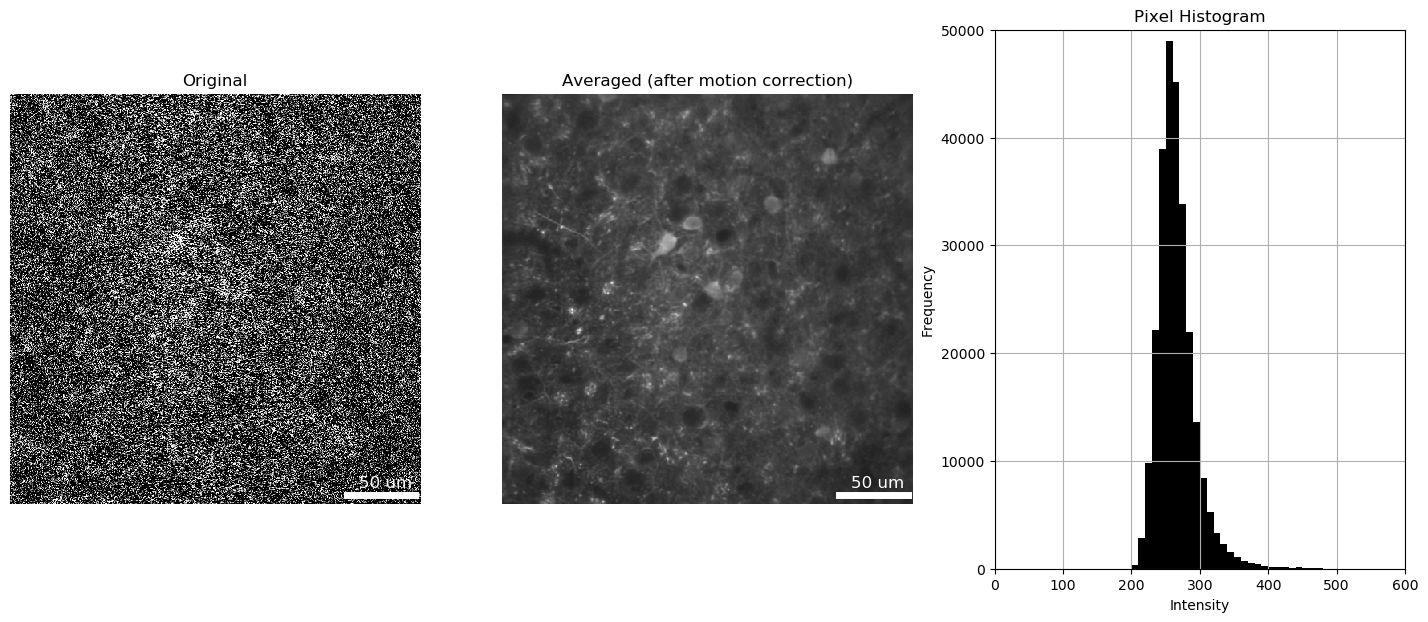

In [7]:
img = tf.imread(path_img)[:, :, 1]
img_org = tf.imread(paths_img_org[0], key=0)
fig = plt.figure(figsize=(18,7))
ax = fig.subplots(1,3)

ax[0].imshow(img_org, cmap='gray', vmin=150, vmax=600)
ax[0].text(435, 490, '50 um', color='w', fontsize=12)
ax[0].plot([420, 420 + 50/0.586], [500,500], LineWidth=5, color='w')
ax[0].axis('off')
ax[0].title.set_text('Original')

ax[1].imshow(img, cmap='gray', vmin=150, vmax=600)
ax[1].text(435, 490, '50 um', color='w', fontsize=12)
ax[1].plot([420, 420 + 50/0.586], [500,500], LineWidth=5, color='w')
ax[1].axis('off')
ax[1].title.set_text('Averaged (after motion correction)')

ax[2].hist(np.ravel(img), np.arange(0, 600, 10), color='k')
ax[2].grid('on')
ax[2].set_xlabel('Intensity')
ax[2].set_ylabel('Frequency')
ax[2].set_ylim(0, 5e4)
ax[2].set_xlim(0, 600)
ax[2].title.set_text('Pixel Histogram') 


In [8]:
# Load ROI data
with open(dot2p_folder / 'roi.pkl', 'rb') as f:
    roi = pickle.load(f)
img_roi = np.squeeze(roi[0]['mask'])

In [9]:
# Change colormap, so I can only color the ROI's 
tab20 = plt.get_cmap('tab20')
tab20_colors = tab20(np.arange(tab20.N))
tab20_colors[0] = [0,0,0,0]
custom_cmap = ListedColormap(tab20_colors)

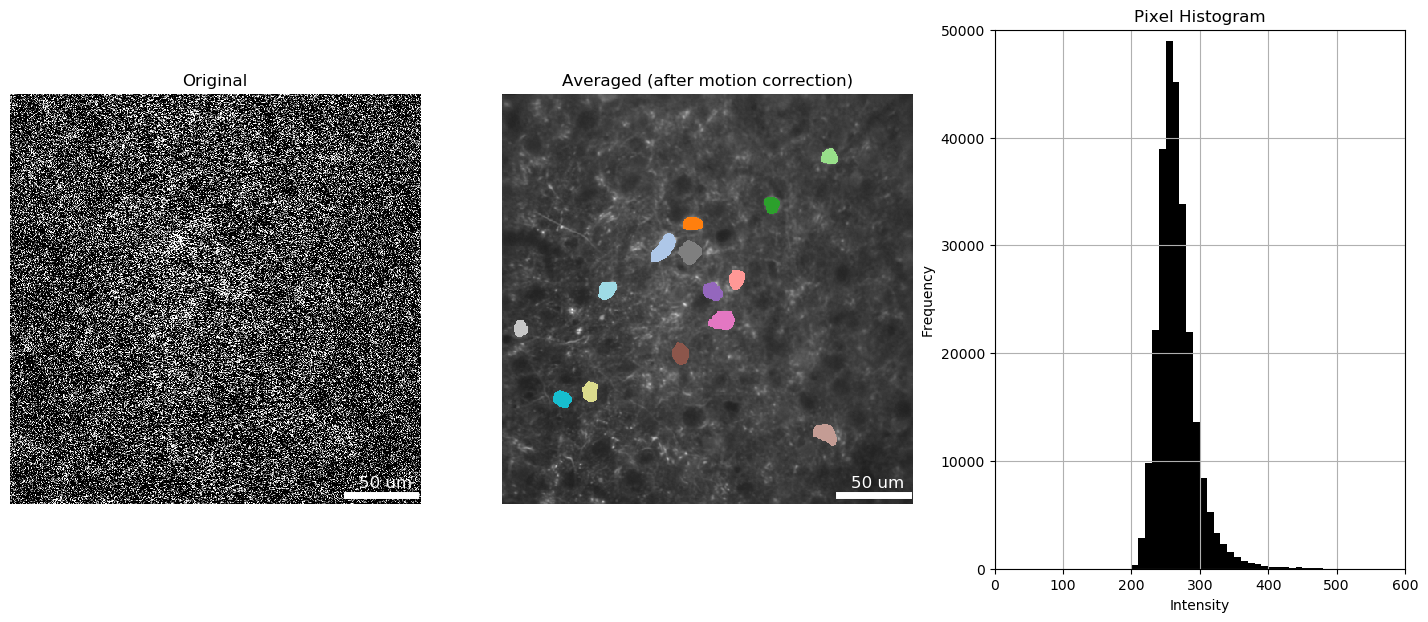

In [110]:
# Create the same image with ROI overlay
img = tf.imread(path_img)[:, :, 1]
img_org = tf.imread(paths_img_org[0], key=0)
fig = plt.figure(figsize=(18,7))
ax = fig.subplots(1,3)

ax[0].imshow(img_org, cmap='gray', vmin=150, vmax=600)
ax[0].text(435, 490, '50 um', color='w', fontsize=12)
ax[0].plot([420, 420 + 50/0.586], [500,500], LineWidth=5, color='w')
ax[0].axis('off')
ax[0].title.set_text('Original')

ax[1].imshow(img, cmap='gray', vmin=150, vmax=600)
ax[1].imshow(img_roi, cmap=custom_cmap)
ax[1].text(435, 490, '50 um', color='w', fontsize=12)
ax[1].plot([420, 420 + 50/0.586], [500,500], LineWidth=5, color='w')
ax[1].axis('off')
ax[1].title.set_text('Averaged (after motion correction)')

ax[2].hist(np.ravel(img), np.arange(0, 600, 10), color='k')
ax[2].grid('on')
ax[2].set_xlabel('Intensity')
ax[2].set_ylabel('Frequency')
ax[2].set_ylim(0, 5e4)
ax[2].set_xlim(0, 600)
ax[2].title.set_text('Pixel Histogram') 


In [11]:
# Load Timing Data
path_stim = path_dataset / 'Episode001.h5'

In [13]:
stim_data = h5py.File(path_stim, 'r')

In [122]:
stimulation.shape

(314700, 1)

(0, 12)

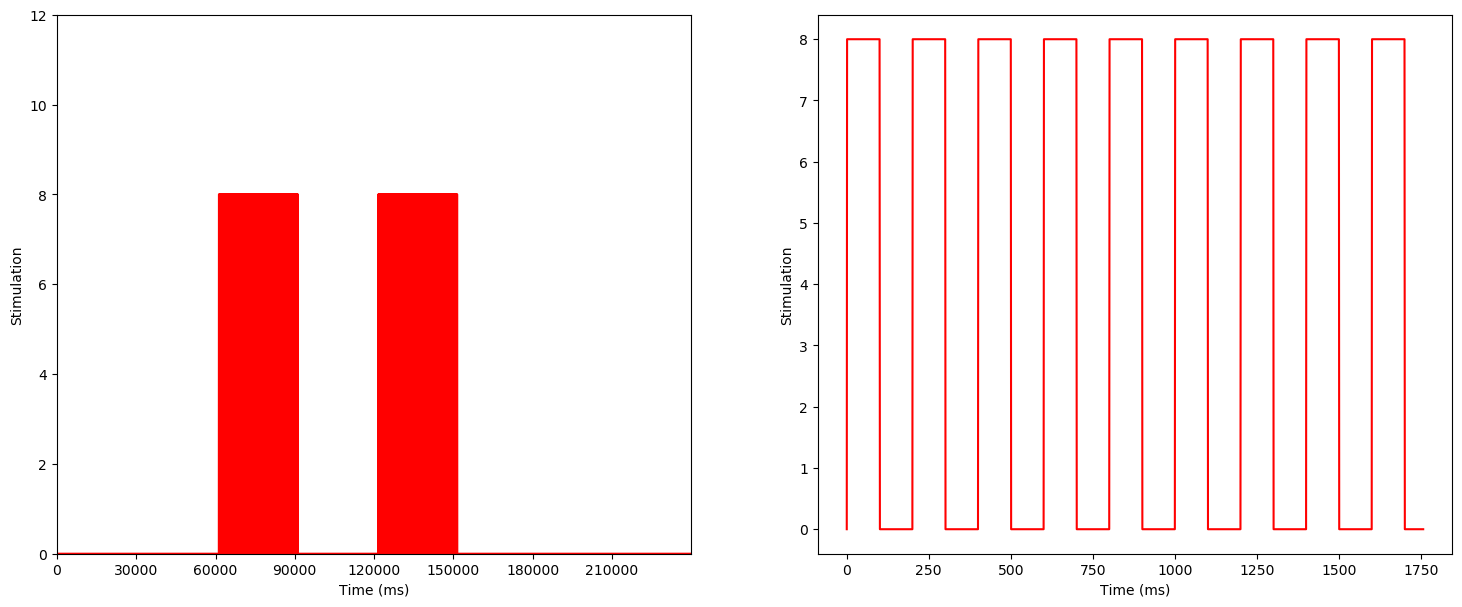

In [124]:
# Down sample. Origianl one is in 100kHz. Turn down to 1kHz
stimulation = np.array(stim_data['DI']['BleachOut'])[::100]
fig = plt.figure(figsize=(18,7))
ax = fig.subplots(1,2)
ax[0].plot(stimulation, 'r')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Stimulation')
ax[0].set_xlim([0, 240000])
ax[0].set_ylim([0, 12])
ax[0].set_xticks(np.arange(0, 240000, 30000))
ax[1].plot(stimulation[61242:63000], 'r')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Stimulation')
ax[0].set_ylim([0, 12])


In [168]:
# Get Onset/Offset of Stimuli
stim_points = np.where(stimulation != 0)[0]

stim1 = [stim_points[0], stim_points[stim_points < 2 * 60 * 1000][-1]] # Used 2 minutes as a threshold
stim2 = [stim_points[stim_points > 2 * 60 * 1000][0], stim_points[-1]]

print(f"First stim onset: {stim1[0] / 1000} sec")
print(f"First stim offset: {stim1[1] / 1000} sec") 

print(f"Second stim onset: {stim2[0] / 1000} sec")
print(f"Second stim offset: {stim2[1] / 1000} sec")


First stim onset: 61.243 sec
First stim offset: 91.142 sec
Second stim onset: 121.552 sec
Second stim offset: 151.451 sec


In [102]:
# Get Onset/Offset in frame number (signal)
# First, down sample to 1kHz and get edge of pulse
frame_out = np.diff(np.squeeze(np.array(stim_data['DI']['FrameOut'])[::100]))
print(np.unique(frame_out))


[         0          2 4294967294]


In [103]:
# It looks like frame is acquired during value of 2
# There is additional points in the end, so I take only first 7200 points
frame_points = np.where(frame_out == 2)[0][:7200]
print(frame_points)


[   612    645    678 ... 240707 240741 240774]


In [170]:
# Find the Onset and Offset index of two stimuli
stim1_frame = [np.argmin(np.abs(frame_points - stim1[0])), np.argmin(np.abs(frame_points - stim1[1]))]
stim2_frame = [np.argmin(np.abs(frame_points - stim2[0])), np.argmin(np.abs(frame_points - stim2[1]))]
print(stim1_frame)
print(stim2_frame)

[1818, 2714]
[3625, 4522]


In [171]:
# Import Signal
path_sig = dot2p_folder / 'dFoF.pkl'
path_sig_raw = dot2p_folder / 'F.pkl'
with open(path_sig, 'rb') as f:
    sig = pickle.load(f)
with open(path_sig_raw, 'rb') as f:
    sig_raw = pickle.load(f)

In [172]:
uuids = list(sig.keys())
numROI = len(uuids)
signals = []
signals_raw = []
for i in range(numROI):
    signals.append(sig[uuids[i]])
    signals_raw.append(sig_raw[uuids[i]])
signals = np.array(signals).T
signals_raw = np.array(signals_raw).T
lengthSignal = signals.shape[0]
print(f'Number of ROI: {numROI}')
print(f'Length of Signal: {lengthSignal}')

Number of ROI: 14
Length of Signal: 7200


In [173]:
frame_points

array([   612,    645,    678, ..., 240707, 240741, 240774], dtype=int64)

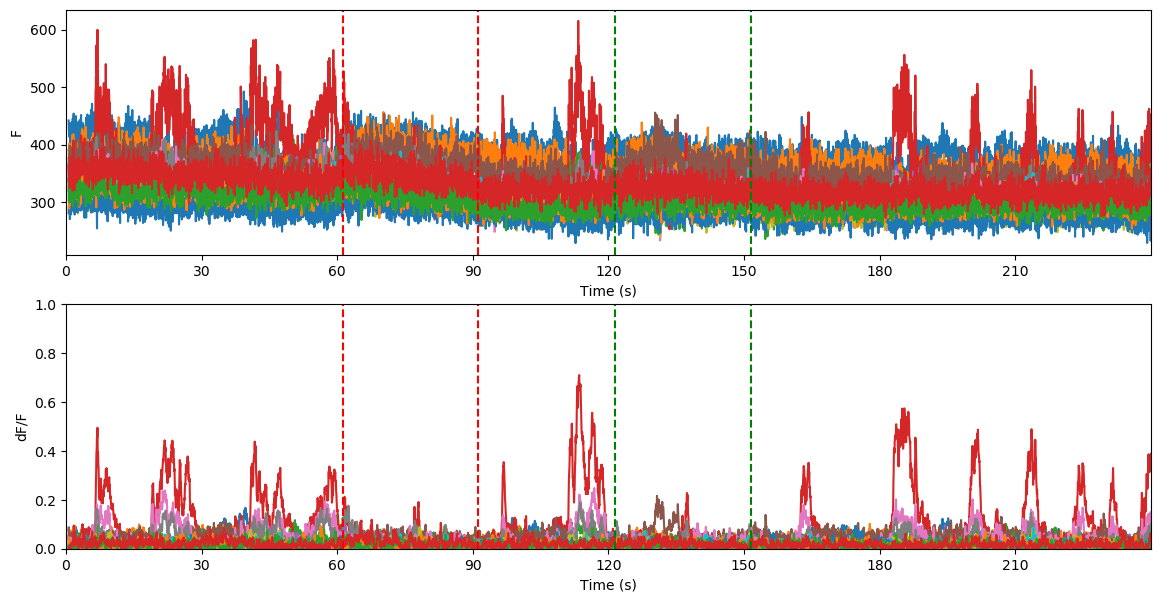

In [174]:
fig = plt.figure(figsize=(14,7))
ax = fig.subplots(2,1)
ax[0].plot(frame_points, signals_raw)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('F')
ax[0].set_xlim([0, 240000])
ax[0].set_xticks(np.arange(0, 240000, 30000))
ax[0].set_xticklabels(np.arange(0, 240, 30))
#ax.set_ylim([0, 1])

# draw vertical lines for onset and offset
ax[0].axvline(stim1[0], color='r', linestyle='--')
ax[0].axvline(stim1[1], color='r', linestyle='--')
ax[0].axvline(stim2[0], color='g', linestyle='--')
ax[0].axvline(stim2[1], color='g', linestyle='--')

ax[1].plot(frame_points, signals)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('dF/F')
ax[1].set_xlim([0, 240000])
ax[1].set_xticks(np.arange(0, 240000, 30000))
ax[1].set_xticklabels(np.arange(0, 240, 30))
ax[1].set_ylim([0, 1])

# draw vertical lines for onset and offset
ax[1].axvline(stim1[0], color='r', linestyle='--')
ax[1].axvline(stim1[1], color='r', linestyle='--')
ax[1].axvline(stim2[0], color='g', linestyle='--')
ax[1].axvline(stim2[1], color='g', linestyle='--')



Text(0.5, 1.0, 'ROI 0')

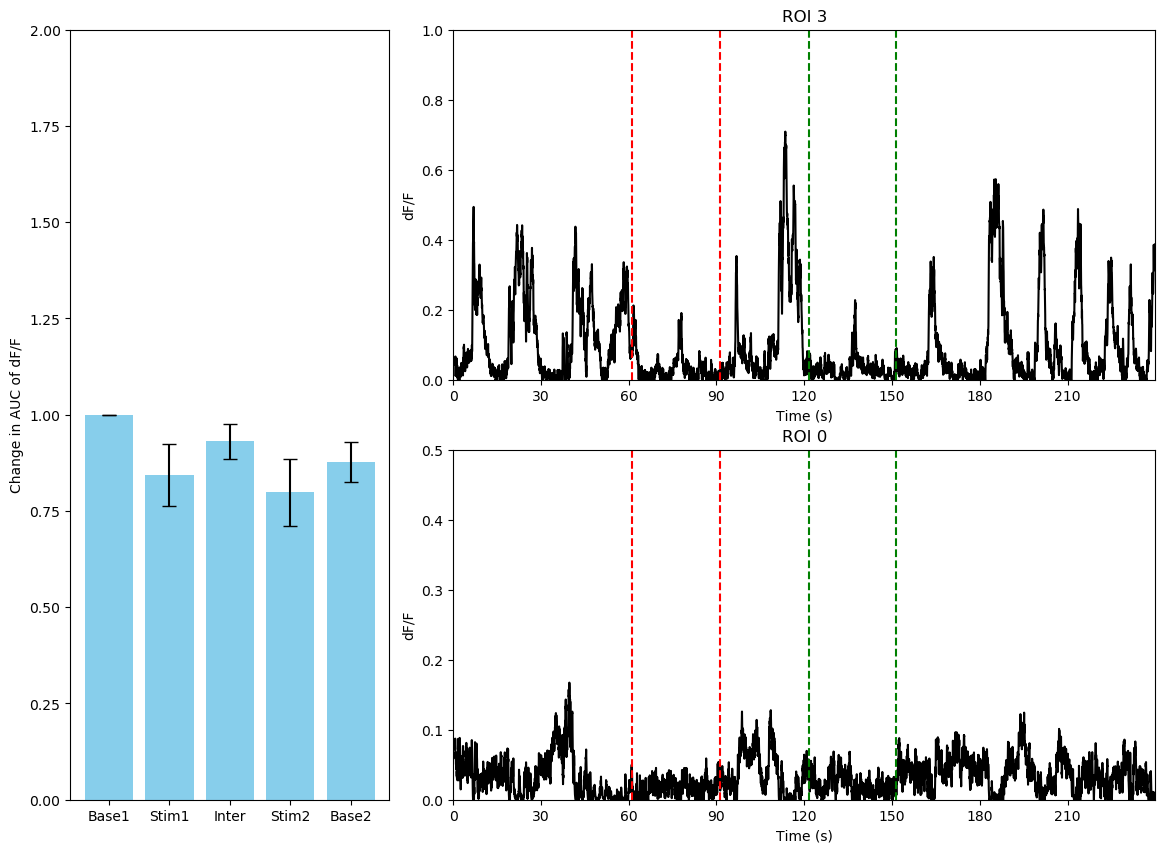

In [213]:
base1_sig = signals[:stim1_frame[0], :]
stim1_sig = signals[stim1_frame[0]:stim1_frame[1], :]
inter_sig = signals[stim1_frame[1]:stim2_frame[0], :]
stim2_sig = signals[stim2_frame[0]:stim2_frame[1], :]
base2_sig = signals[stim2_frame[1]:, :]

auc_base1 = np.mean(base1_sig, axis=0)
auc_stim1 = np.mean(stim1_sig, axis=0) / auc_base1
auc_inter = np.mean(inter_sig, axis=0) / auc_base1
auc_stim2 = np.mean(stim2_sig, axis=0) / auc_base1
auc_base2 = np.mean(base2_sig, axis=0) / auc_base1

# Concat all into 2D array
final_data = np.vstack([np.ones_like(auc_base1), auc_stim1, auc_inter, auc_stim2, auc_base2])

# Plot AUC of each ROI as line graph
fig = plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(2, 3)
ax1 = fig.add_subplot(gs[:, 0])  
# calc sem
errors = np.std(final_data, axis=1) / np.sqrt(numROI)
ax1.bar(['Base1', 'Stim1', 'Inter', 'Stim2', 'Base2'], np.mean(final_data, axis=1), yerr=errors, capsize=5, color='skyblue')
ax1.set_ylim([0, 2])
ax1.set_ylabel('Change in AUC of dF/F')

ax3 = fig.add_subplot(gs[0, 1:3])
ax3.plot(frame_points, signals[:, 3], 'k')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('dF/F')
ax3.set_xlim([0, 240000])
ax3.set_xticks(np.arange(0, 240000, 30000))
ax3.set_xticklabels(np.arange(0, 240, 30))
ax3.set_ylim([0, 1])
ax3.axvline(stim1[0], color='r', linestyle='--')
ax3.axvline(stim1[1], color='r', linestyle='--')
ax3.axvline(stim2[0], color='g', linestyle='--')
ax3.axvline(stim2[1], color='g', linestyle='--')
ax3.set_title('ROI 3')


ax4 = fig.add_subplot(gs[1, 1:3])
ax4.plot(frame_points, signals[:, 0], 'k')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('dF/F')
ax4.set_xlim([0, 240000])
ax4.set_xticks(np.arange(0, 240000, 30000))
ax4.set_xticklabels(np.arange(0, 240, 30))
ax4.set_ylim([0, 0.5])
ax4.axvline(stim1[0], color='r', linestyle='--')
ax4.axvline(stim1[1], color='r', linestyle='--')
ax4.axvline(stim2[0], color='g', linestyle='--')
ax4.axvline(stim2[1], color='g', linestyle='--')
ax4.set_title('ROI 0')
